In [1]:
# Imports
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Dataset

import os
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
torch.cuda.empty_cache()

import sys
# Add the upper directory to the path
sys.path.append("../Models/")
from CustomCNNVessel import CustomResNet

torch.cuda.empty_cache()

In [2]:
model = CustomResNet(num_classes=2).to('cuda')
# Load the weights
model.load_state_dict(torch.load(f"../Models/custom_cnn_vessel.pth"))

model_regularized_l1 = CustomResNet(num_classes=2).to('cuda')
# Load the weights
model_regularized_l1.load_state_dict(torch.load(f"../Models/custom_cnn_vessel_regularized_l1.pth"))

model_regularized_l2 = CustomResNet(num_classes=2).to('cuda')
# Load the weights
model_regularized_l2.load_state_dict(torch.load(f"../Models/custom_cnn_vessel_regularized_l2.pth"))

<All keys matched successfully>

In [3]:
def get_model_weights(model):
    weights = []
    for name, param in model.named_parameters():
        if 'weight' in name:  # Ensure we're only looking at weights, not biases
            weights.append(param.detach().cpu().numpy())  # Convert to numpy array
    return weights

In [4]:
threshold = 0.1  # Define your threshold

def analyze_weights(weights, threshold):
    # Flatten each weight matrix and perform the comparison
    above_threshold = sum(np.count_nonzero(np.abs(weight.flatten()) > threshold) for weight in weights)
    below_threshold = sum(np.count_nonzero(np.abs(weight.flatten()) <= threshold) for weight in weights)
    sparsity = sum(np.count_nonzero(np.abs(weight.flatten()) < 1e-5) for weight in weights)  # Adjust the threshold for sparsity as needed
    return above_threshold, below_threshold, sparsity



weights_model = get_model_weights(model)
weights_model_l1 = get_model_weights(model_regularized_l1)
weights_model_l2 = get_model_weights(model_regularized_l2)

analysis_model = analyze_weights(weights_model, threshold)
analysis_model_l1 = analyze_weights(weights_model_l1, threshold)
analysis_model_l2 = analyze_weights(weights_model_l2, threshold)


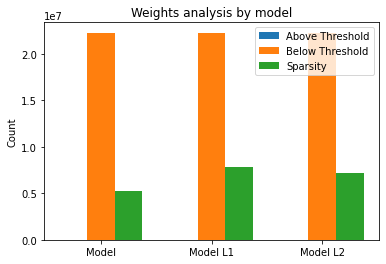

In [5]:
labels = ['Model', 'Model L1', 'Model L2']
above_threshold_values = [analysis_model[0], analysis_model_l1[0], analysis_model_l2[0]]
below_threshold_values = [analysis_model[1], analysis_model_l1[1], analysis_model_l2[1]]
sparsity_values = [analysis_model[2], analysis_model_l1[2], analysis_model_l2[2]]

x = np.arange(len(labels))  # Label locations
width = 0.25  # Width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, above_threshold_values, width, label='Above Threshold')
rects2 = ax.bar(x, below_threshold_values, width, label='Below Threshold')
rects3 = ax.bar(x + width, sparsity_values, width, label='Sparsity')

# Add some text for labels, title, and custom x-axis tick labels
ax.set_ylabel('Count')
ax.set_title('Weights analysis by model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

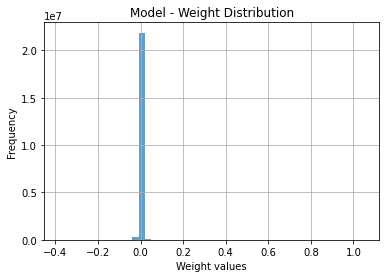

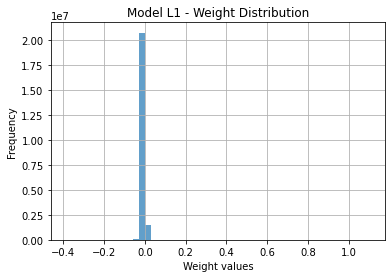

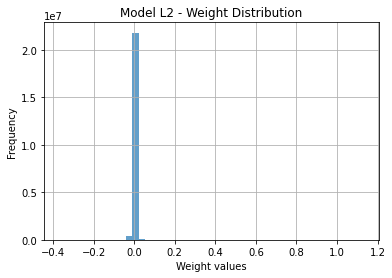

In [6]:
import matplotlib.pyplot as plt

def plot_weight_histogram(weights, title):
    # Flatten all weight arrays and combine them into one list
    all_weights = np.hstack([w.flatten() for w in weights])

    plt.hist(all_weights, bins=50, alpha=0.7)
    plt.title(title)
    plt.xlabel('Weight values')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

plot_weight_histogram(weights_model, "Model - Weight Distribution")
plot_weight_histogram(weights_model_l1, "Model L1 - Weight Distribution")
plot_weight_histogram(weights_model_l2, "Model L2 - Weight Distribution")

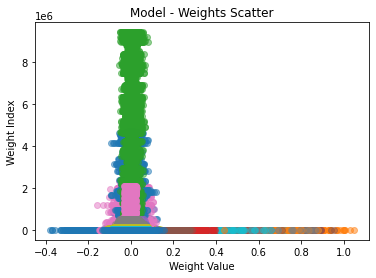

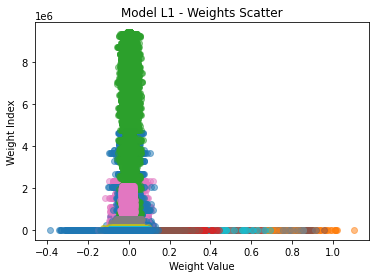

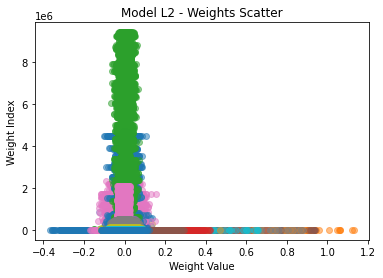

In [9]:
def plot_weight_scatter(weights, title):
    fig, ax = plt.subplots()
    for w in weights:
        ax.scatter(w.flatten(), range(len(w.flatten())), alpha=0.5)

    plt.title(title)
    plt.xlabel('Weight Value')
    plt.ylabel('Weight Index')
    plt.show()

plot_weight_scatter(weights_model, "Model - Weights Scatter")
plot_weight_scatter(weights_model_l1, "Model L1 - Weights Scatter")
plot_weight_scatter(weights_model_l2, "Model L2 - Weights Scatter")